In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartbeat/ptbdb_abnormal.csv
/kaggle/input/heartbeat/ptbdb_normal.csv
/kaggle/input/heartbeat/mitbih_test.csv
/kaggle/input/heartbeat/mitbih_train.csv


# **CNN for MIT-BIH Arrhythmia Dataset**

# Importing data

In [2]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
train_data = pd.read_csv("/kaggle/input/heartbeat/mitbih_train.csv", header = None) 
train_data=pd.DataFrame(train_data)
test_data = pd.read_csv("../input/heartbeat/mitbih_test.csv", header = None)
test_data=pd.DataFrame(test_data)


# Data Preprocessing

In [4]:
train_data.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [5]:
train_data.describe().T  

,count,mean,std,min,25%,50%,75%,max
0,87554.0,0.890360,0.240909,0.0,0.921922,0.991342,1.000000,1.0
1,87554.0,0.758160,0.221813,0.0,0.682486,0.826013,0.910506,1.0
2,87554.0,0.423972,0.227305,0.0,0.250969,0.429472,0.578767,1.0
3,87554.0,0.219104,0.206878,0.0,0.048458,0.166000,0.341727,1.0
4,87554.0,0.201127,0.177058,0.0,0.082329,0.147878,0.258993,1.0
...,...,...,...,...,...,...,...,...
183,87554.0,0.003471,0.036255,0.0,0.000000,0.000000,0.000000,1.0
184,87554.0,0.003221,0.034789,0.0,0.000000,0.000000,0.000000,1.0
185,87554.0,0.002945,0.032865,0.0,0.000000,0.000000,0.000000,1.0
186,87554.0,0.002807,0.031924,0.0,0.000000,0.000000,0.000000,1.0


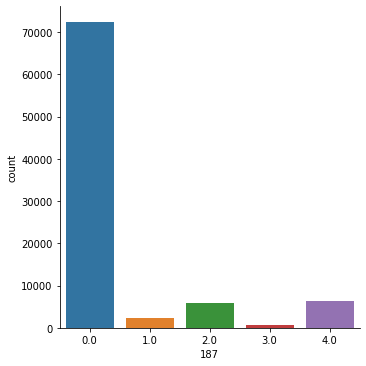

In [6]:
# Display counts of each classes - Most of Data samples are of normal HeartBeats & its a biased data
sns.catplot(x = 187, kind = 'count', data = train_data)

> Divide data into 5 classes

In [7]:
class_0=train_data[train_data[187]==0.0]
class_1=train_data[train_data[187]==1.0]
class_2=train_data[train_data[187]==2.0]
class_3=train_data[train_data[187]==3.0]
class_4=train_data[train_data[187]==4.0]
train_data = pd.concat([class_1, class_2, class_3, class_4, class_0])


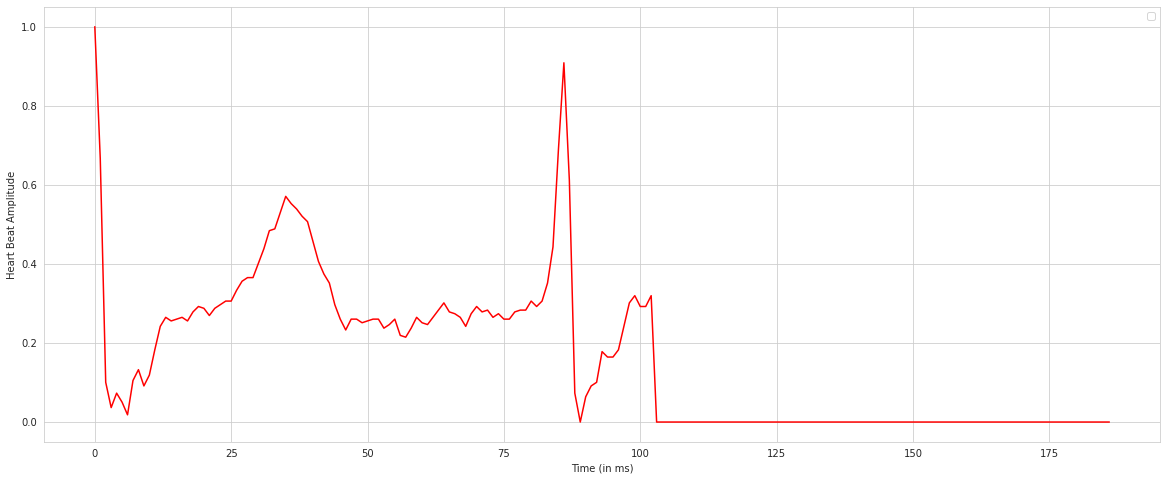

In [8]:
sns.set_style('whitegrid')
plt.figure(figsize = (20,8))
plt.plot(train_data.iloc[0, 0:187], color = 'red')
plt.xlabel("Time (in ms)")
plt.ylabel("Heart Beat Amplitude")
plt.legend()
plt.show()

**Balance data**

> Upsample

In [9]:
from sklearn.utils import resample

class_1_upsample = resample(class_1, n_samples = 20000, replace = True, random_state = 123)
class_2_upsample = resample(class_2, n_samples = 20000, replace = True, random_state = 123)
class_3_upsample = resample(class_3, n_samples = 20000, replace = True, random_state = 123)
class_4_upsample = resample(class_4, n_samples = 20000, replace = True, random_state = 123)

> Downsample

In [10]:
class_0_downsample = resample(class_0, n_samples = 20000, replace = True, random_state = 123)

In [11]:
train_data = pd.concat([class_1_upsample, class_2_upsample, class_3_upsample, class_4_upsample, class_0_downsample])

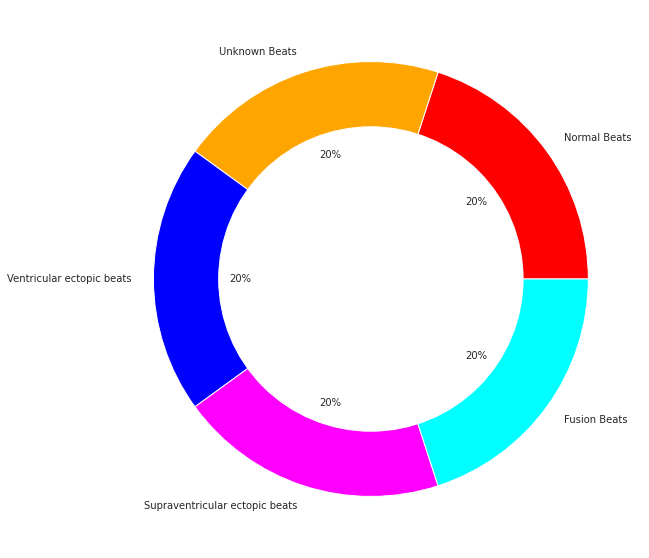

In [12]:
plt.figure(figsize= (10,10))
my_circle = plt.Circle((0,0), 0.7, color = 'white') 
plt.pie(train_data[187].value_counts(), labels=['Normal Beats','Unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats',
                                                'Fusion Beats'], autopct = '%0.0f%%', colors = ['red','orange','blue','magenta','cyan'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#  Apply Keras Models

In [13]:
from keras.utils import to_categorical
Y=train_data.values[:, -1].astype(int)
y=to_categorical(Y)
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop([187], axis=1), y, test_size = 0.3)

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(187,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history=model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

print("Evaluation: ")
mse, acc = model.evaluate(X_valid, y_valid)
print('mean_squared_error :', mse)
print('accuracy:', acc)



Epoch 1/20
2188/2188 [==============================] - 5s 2ms/step - loss: 0.7203 - accuracy: 0.7436 - val_loss: 0.3694 - val_accuracy: 0.8602
Epoch 2/20
2188/2188 [==============================] - 4s 2ms/step - loss: 0.3421 - accuracy: 0.8706 - val_loss: 0.2913 - val_accuracy: 0.8955
Epoch 3/20
2188/2188 [==============================] - 4s 2ms/step - loss: 0.2755 - accuracy: 0.8982 - val_loss: 0.2398 - val_accuracy: 0.9134
Epoch 4/20
2188/2188 [==============================] - 4s 2ms/step - loss: 0.2354 - accuracy: 0.9143 - val_loss: 0.2190 - val_accuracy: 0.9264
Epoch 5/20
2188/2188 [==============================] - 4s 2ms/step - loss: 0.2071 - accuracy: 0.9262 - val_loss: 0.2030 - val_accuracy: 0.9284
Epoch 6/20
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1866 - accuracy: 0.9340 - val_loss: 0.1674 - val_accuracy: 0.9465
Epoch 7/20
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1644 - accuracy: 0.9431 - val_loss: 0.1642 - val_accuracy:

Minimum Validation Loss: 0.0938


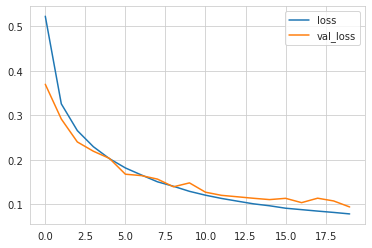

In [15]:
history_df = pd.DataFrame(history.history)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));